In [1]:
from model import AGC_STFT_GRU
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

/home/yhjeon/anaconda3/envs/denoiser/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = AGC_STFT_GRU(160, 10, 160, 80)   
package = torch.load('/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/AGC_endtoend_r1.pth.tar')
model.load_state_dict(package['state_dict'])

model.cpu()
model.eval()


AGC_STFT_GRU(
  (relu): ReLU()
  (gru): GRU(81, 10, batch_first=True)
  (lin): Linear(in_features=10, out_features=1, bias=True)
  (upsample): Upsample(scale_factor=80.0, mode=nearest)
)

/home/yhjeon/anaconda3/envs/denoiser/lib/python3.7/site-packages/torch/functional.py:633: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:801.)
  normalized, onesided, return_complex)


1 프레임 지연시간: 10.0 ms
frame by frame inference 일치 여부: 1


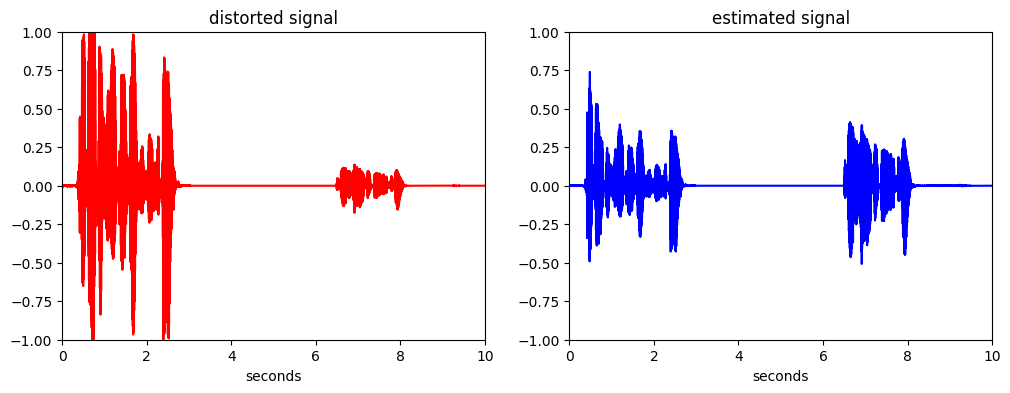

1 프레임 지연시간: 10.0 ms
frame by frame inference 일치 여부: 1


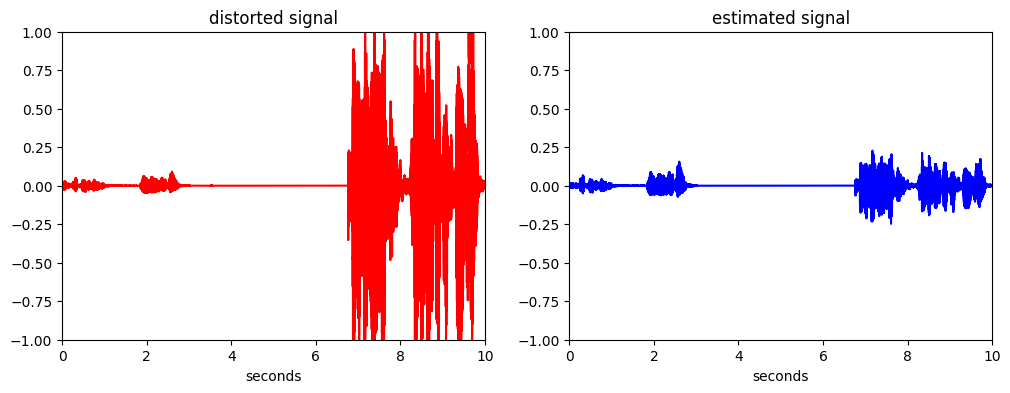

1 프레임 지연시간: 10.0 ms
frame by frame inference 일치 여부: 1


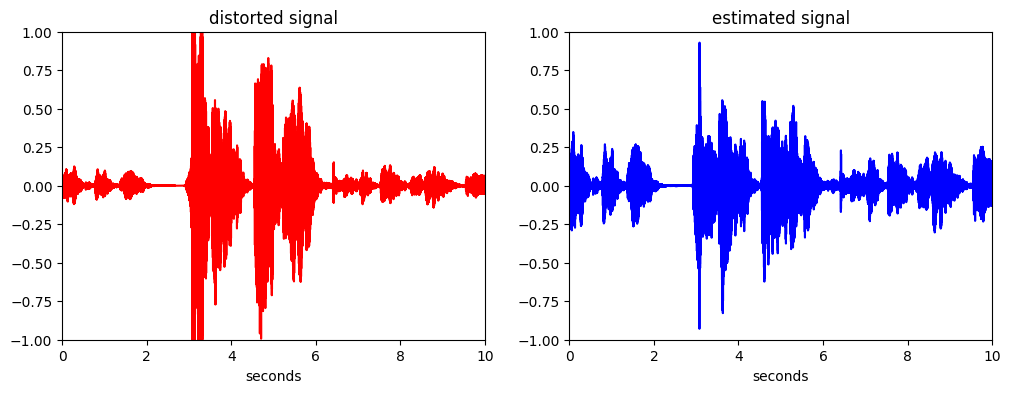

1 프레임 지연시간: 10.0 ms
frame by frame inference 일치 여부: 1


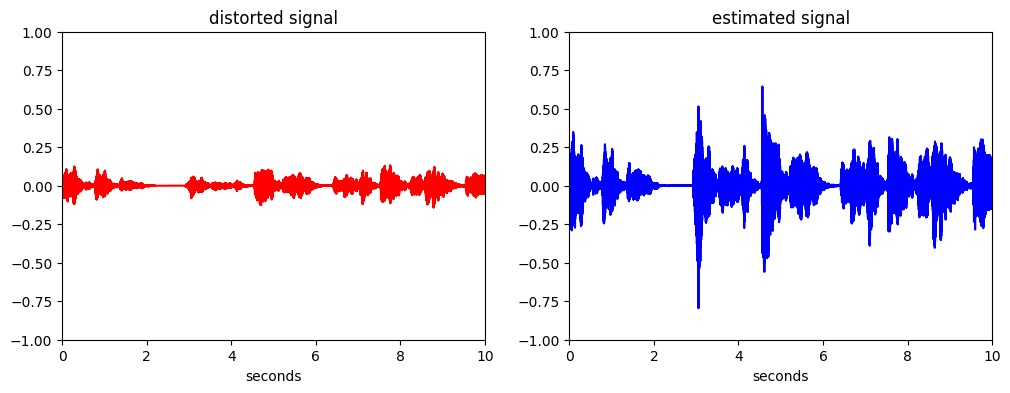

In [3]:
import time
import soundfile as sf
import numpy as np

for i in range(4):
    frame_time_max = 0

    start = time.time()

    wav = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/samples/wave_distorted_{0}.wav'.format(i))[0]

    wav = torch.FloatTensor(wav)

    wav = wav.unsqueeze(0).cpu()

    est, _ = model(wav)

    hidden = None

    allclose = 1

    # dns-challenge 기준으로 1 프레임 지연시간 측정
    print('1 프레임 지연시간: {0:.1f} ms'.format((model.win_len / 16 - model.hop_len / 16) + model.hop_len / 16))

    for frame in range(1000):
        start = time.time()
        wav_frame = wav[...,frame*80:(frame+2)*80]
        est_frame, hidden = model(wav_frame, hidden)
        end  = time.time()
        elapsed = end - start

        xaxis = np.arange(0, 10, 1/16000)
        xaxis_frame = np.arange(0, 0.005, 1/16000)

        if frame_time_max < elapsed:
            frame_time_max = elapsed

        if frame > 0:
            # 10ms win, 5ms hop 단위로 inference시 전체 inference와 같은 결과가 나오는지 확인
            if torch.allclose(est[...,(frame+1)*80:(frame+2)*80], est_frame):
                pass
            else:
                allclose = 0 # 같은 결과가 나오지 않는 frame이 있는 경우
        
        # if frame > 100 and frame < 104:
        #     plt.figure(figsize=[12, 4])
        #     plt.subplot(1, 2, 1)
        #     plt.axis([0, 0.005, -1, 1])
        #     plt.plot(xaxis_frame, wav_frame[0][80:].cpu(), color='red')
        #     plt.xlabel('seconds')
        #     plt.title('distorted signal(1 frame)')
        #     plt.subplot(1, 2, 2)
        #     plt.axis([0, 0.005, -1, 1])
        #     plt.plot(xaxis_frame, est_frame[0].cpu().detach(), color='blue')
        #     plt.xlabel('seconds')
        #     plt.title('estimated signal(1 frame)')
        
    print('frame by frame inference 일치 여부: {0}'.format(allclose)) #일치하는 경우 1, 아닌 경우 0 

    est = est[0].cpu().detach()

    wav = wav[0].cpu()

    # plot


    plt.figure(figsize=[12, 4])
    plt.subplot(1, 2, 1)
    plt.axis([0, 10, -1, 1])
    plt.plot(xaxis, wav, color='red')
    plt.xlabel('seconds')
    plt.title('distorted signal')
    plt.subplot(1, 2, 2)
    plt.axis([0, 10, -1, 1])
    plt.plot(xaxis, est, color='blue')
    plt.xlabel('seconds')
    plt.title('estimated signal')
    plt.show()
